In [14]:
datasetdir = 'C:\\Users\\reekithak\\Audio_Models\\Data\\Images'
import os
os.chdir(datasetdir)

import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32
def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        #horizontal_flip = True, 
        validation_split = 0.25,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('bad','good'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('bad','good'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [16]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [17]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False)


In [18]:
train_dataset, val_dataset = generators((224,224), preprocessing=vgg16.preprocess_input)

Found 1662 images belonging to 2 classes.
Found 554 images belonging to 2 classes.


In [19]:
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [20]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
# final softmax layer with two categories (dog and cat)
predictions = keras.layers.Dense(2, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

In [21]:
for layer in conv_model.layers:
    layer.trainable = False

In [22]:
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [23]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
EARLY_STOP_PATIENCE = 3
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'C:\\Users\\reekithak\\Audio_Models\\new_vgg16.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [24]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['accuracy']
                  )


In [25]:
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    epochs=15,
    workers=10,
    callbacks=[cb_checkpointer, cb_early_stopper]
)
full_model.load_weights('C:\\Users\\reekithak\\Audio_Models\\new_vgg16.hdf5')

Epoch 1/15
52/52 [==============================] - 397s 8s/step - loss: 1.8035 - accuracy: 0.7921 - val_loss: 0.7695 - val_accuracy: 0.8087
Epoch 2/15
52/52 [==============================] - 397s 8s/step - loss: 0.0715 - accuracy: 0.9801 - val_loss: 0.3303 - val_accuracy: 0.8773
Epoch 3/15
52/52 [==============================] - 1673s 33s/step - loss: 0.0126 - accuracy: 0.9961 - val_loss: 0.3192 - val_accuracy: 0.8953
Epoch 4/15
52/52 [==============================] - 1534s 30s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3833 - val_accuracy: 0.8827
Epoch 5/15
52/52 [==============================] - 1776s 34s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3545 - val_accuracy: 0.8881
Epoch 6/15
52/52 [==============================] - 1779s 34s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.3717 - val_accuracy: 0.8863


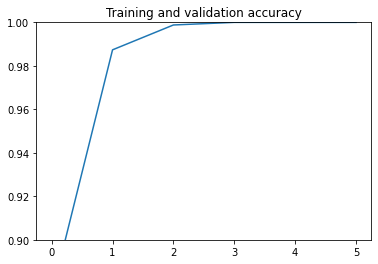

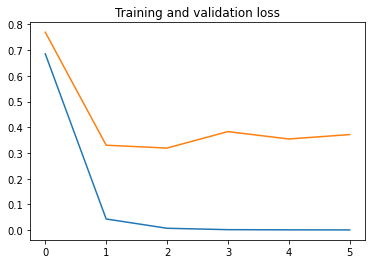

In [26]:
plot_history(history, yrange=(0.9,1))

In [27]:
full_model.save('new_vgg16.h5')

**Prediction**